# RandomForestRegressor

This notebook presents **a customized implementation of the random forest** algorithm in **regression mode**, allowing users to:

1. Define **their own splitting metric** for node decisions.
2. Enable node splitting based on one or **multiple conditions simultaneously**.

> **Reminder of splitting optimization (Regression Trees):**
>
> Splitting in a regression decision tree is achieved by **optimizing a metric**. For regression, the metric is based on the **reduction in variance (or MSE)** after a split. The goal is to **maximize** the decrease in error, i.e. the improvement in prediction homogeneity.
>
> * **The Mean Squared Error (MSE)** of a group of observations is defined as:
>
> $$
> I_{MSE} = \frac{1}{N}\sum_{i=1}^{N}(y_i - \bar{y})^2
> $$
>
> where $y_i$ are the target values in the node and $\bar{y}$ is their mean.
>
> * The metric to be maximized is $\Delta_{MSE}$, the difference between **the MSE on the parent node** and **the weighted average of the MSE between the two child nodes** ($L$ and $R$):
>
> $$
> \Delta_{MSE} = I_{MSE} - \frac{N_L}{N} I_{MSE_L} - \frac{N_R}{N} I_{MSE_R}
> $$
>
> At each node, the regression tree algorithm evaluates all possible splits (over all features and thresholds) and selects the one that **maximizes $\Delta_{MSE}$**. Once the optimal split is chosen, the tree is grown by recursively applying this splitting process to the resulting child nodes.


In [1]:
# !pip install pandas

import pandas as pd

from custom_decision_trees import RandomForestRegressor

To illustrate this example, we use data from `titanic.csv`. The goal is to predict the survival of an individual according to various characteristics such as age, sex, etc.

In [2]:
df = (
    pd
    .read_csv("data/boston_housing.csv")
)

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1


**To define your own splitting metric**, you need to create a class derived from the `custom_tree.metrics.MetricBase` model. This class must contain the same methods and object types as inputs and outputs. 

The `metric_data` parameter refers to the portion of the dataset required to compute the splitting metric. It should be provided as an argument to the `.fit` method when training the model.

> **Note**: the algorithm will always maximize the metric. So if you need minimization, the `.compute_metric` method must return the opposite of the metric.

Here is an example of class for the Gini index :

In [3]:
from typing import Dict, Tuple

import numpy as np

from custom_decision_trees.metrics.metric_base import MetricBase


class MSE(MetricBase):

    def __init__(self) -> None:
        pass

    def compute_mse(
            self,
            metric_data: np.ndarray,
        ) -> float:

        y = metric_data[:, 0]

        nb_obs = len(y)

        if nb_obs == 0:
            return 0

        mean_y = np.mean(y)
        mse = np.mean((y - mean_y) ** 2)

        return float(mse)

    def compute_metric(
            self,
            metric_data: np.ndarray,
            mask: np.ndarray,
        ) -> Tuple[float, Dict]:

        mse_parent = self.compute_mse(metric_data)
        mse_side1 = self.compute_mse(metric_data[mask])
        mse_side2 = self.compute_mse(metric_data[~mask])

        delta = (
            mse_parent
            - mse_side1 * np.mean(mask)
            - mse_side2 * (1 - np.mean(mask))
        )

        metadata = {"mse": round(mse_side1, 3)}

        return float(delta), metadata


Next, instantiate the `DecisionTree` by specifying the following parameters:

*   `metric`: an instance of your custom splitting metric class.
*   `nb_max_conditions_per_node`: the maximum number of simultaneous conditions allowed to split a node.
*   Additional standard random forest parameters (see documentation): `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `n_jobs`.

In [4]:
mse = MSE()

random_forest_regressor = RandomForestRegressor(
    metric=mse,
    n_estimators=10,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    nb_max_conditions_per_node=1,
    nb_max_cut_options_per_var=10,
    bootstrap=True,
    max_samples=None,
    n_jobs=1,
)

Train the model using the `.fit` method.

Here, you must provide the `metric_data` portion of the dataset, which will be passed to the `compute_metric` method defined in your custom metric class.

In [5]:
import warnings

warnings.filterwarnings("error")

features = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'LSTAT', 'CAT. MEDV'
]

X = np.array(df[features])
y = np.array(df["MEDV"])
metric_data = np.array(df[["MEDV"]])

random_forest_regressor.fit(
    X=X,
    y=y,
    metric_data=metric_data,
)

Print the tree using `.print_tree` to observe the **optimal metric values** at each node, as well as the metadata returned by your custom metric class.

As you can see, the algorithm has optimized the splits based on the custom metric (in this case, the Gini delta). Since `nb_max_conditions_per_node` was set to 2, the model chose to perform splits using up to two variables simultaneously.

In [6]:
random_forest_regressor.print_forest(
    n_estimators=3,
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

TREE 1:
[0] 506 obs -> delta gini = 0.0 | mean y = 22.62 | {'mse': 82.335}
|   [1] (x["LSTAT"] > 4.74) | 449 obs -> delta gini = 34.99 | mean y = 20.52 | {'mse': 44.807}
|   |   [3] (x["CAT. MEDV"] > 0.0) | 33 obs -> delta gini = 18.02 | mean y = 35.59 | {'mse': 36.193}
|   |   [4] (x["CAT. MEDV"] <= 0.0) | 416 obs -> delta gini = 18.02 | mean y = 19.32 | {'mse': 26.037}
|   [2] (x["LSTAT"] <= 4.74) | 57 obs -> delta gini = 34.99 | mean y = 39.23 | {'mse': 67.355}
|   |   [5] (x["TAX"] > 398.4) | 9 obs -> delta gini = 15.51 | mean y = 48.32 | {'mse': 22.52}
|   |   [6] (x["TAX"] <= 398.4) | 48 obs -> delta gini = 15.51 | mean y = 37.52 | {'mse': 57.34}

TREE 2:
[0] 506 obs -> delta gini = 0.0 | mean y = 22.44 | {'mse': 87.502}
|   [1] (x["LSTAT"] > 9.69) | 292 obs -> delta gini = 39.61 | mean y = 17.05 | {'mse': 26.957}
|   |   [3] (x["AGE"] > 89.0) | 151 obs -> delta gini = 5.1 | mean y = 14.87 | {'mse': 25.019}
|   |   [4] (x["AGE"] <= 89.0) | 141 obs -> delta gini = 5.1 | mean y = 1

For more visual interpretation, you can also obtain a graph with the `.plot_tree` method.

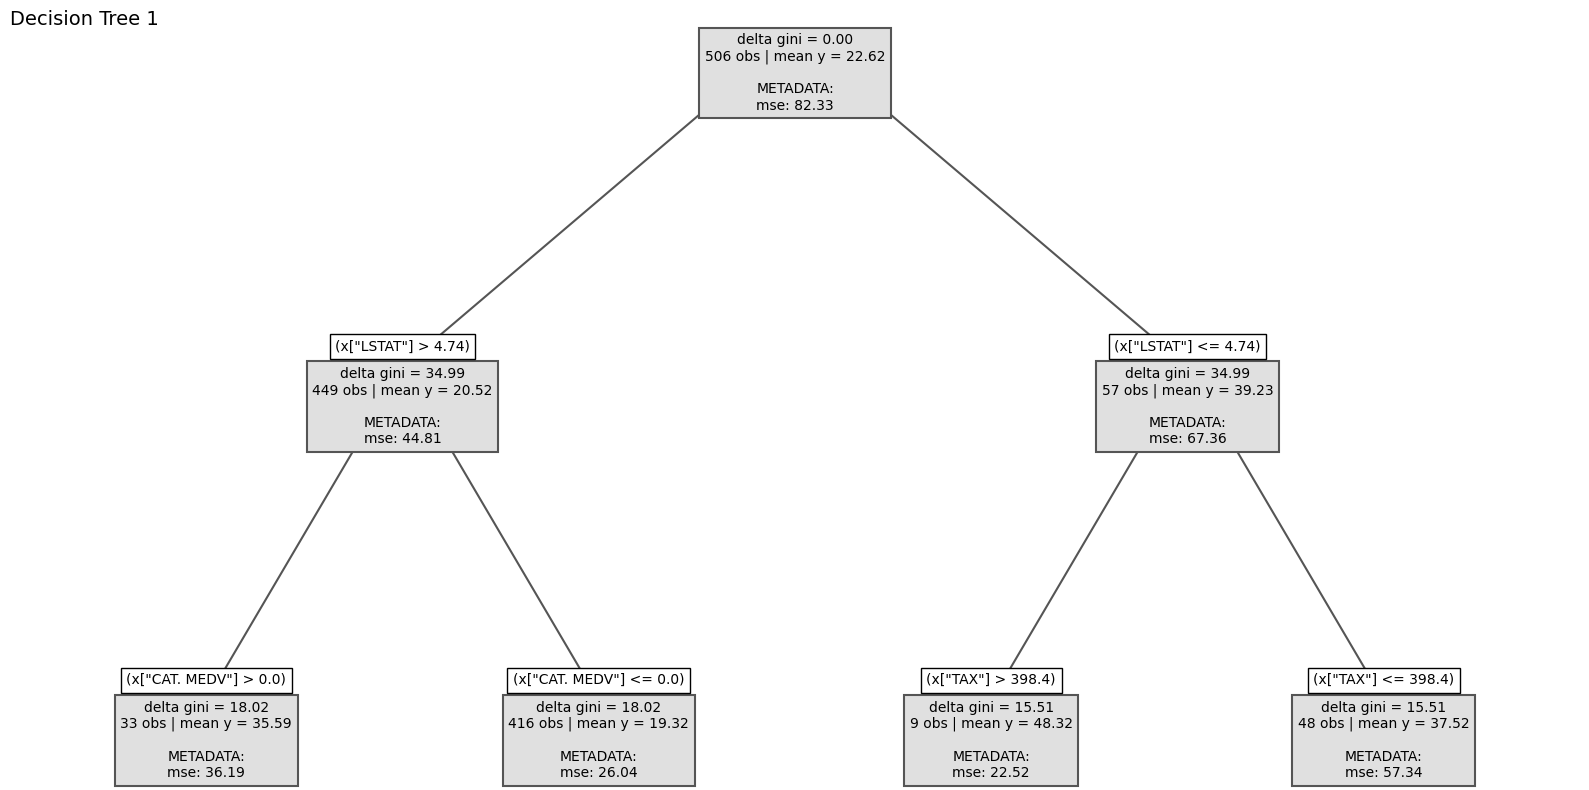

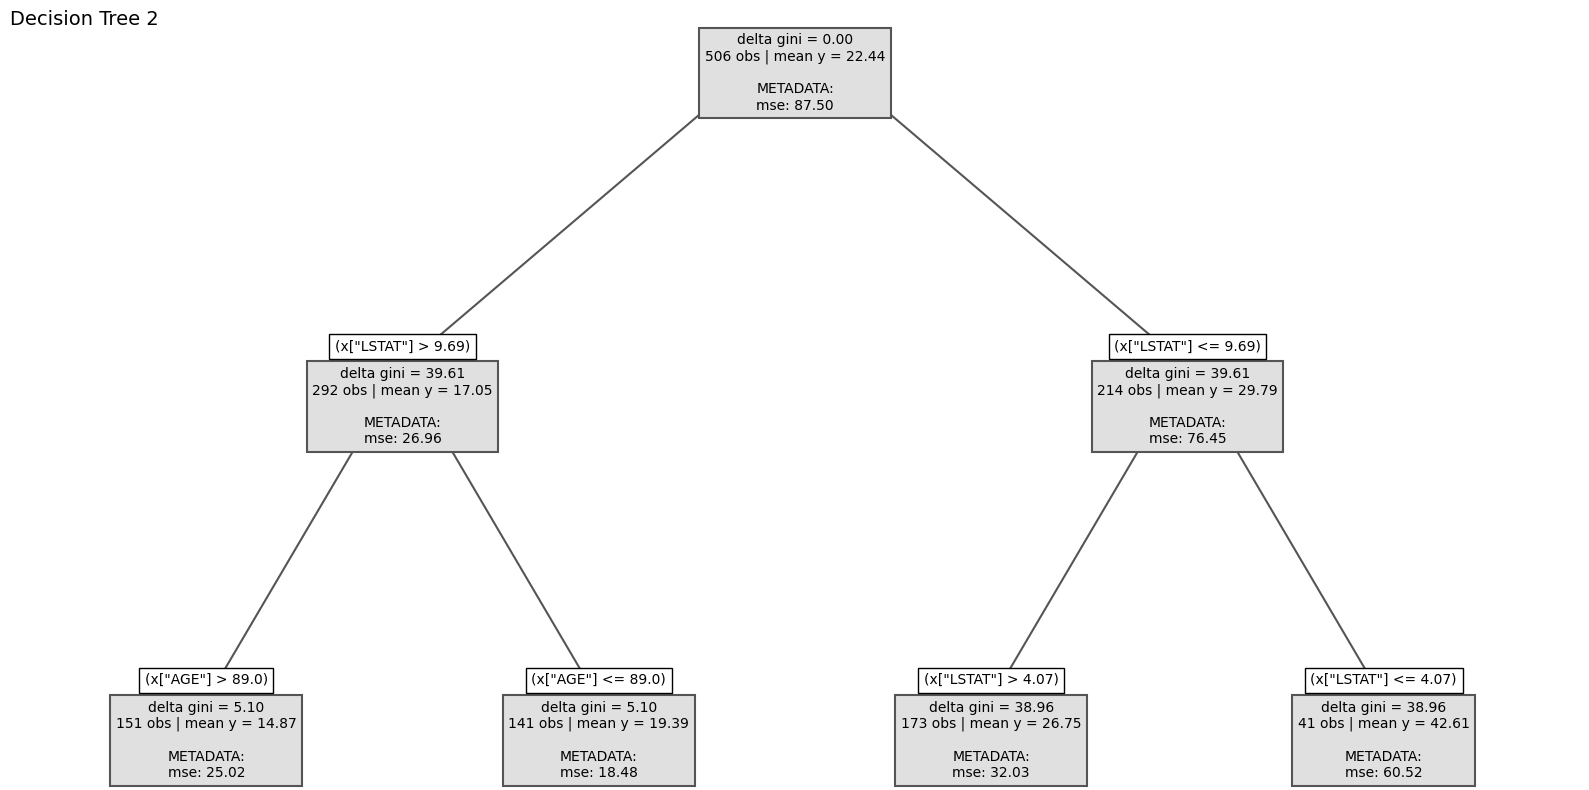

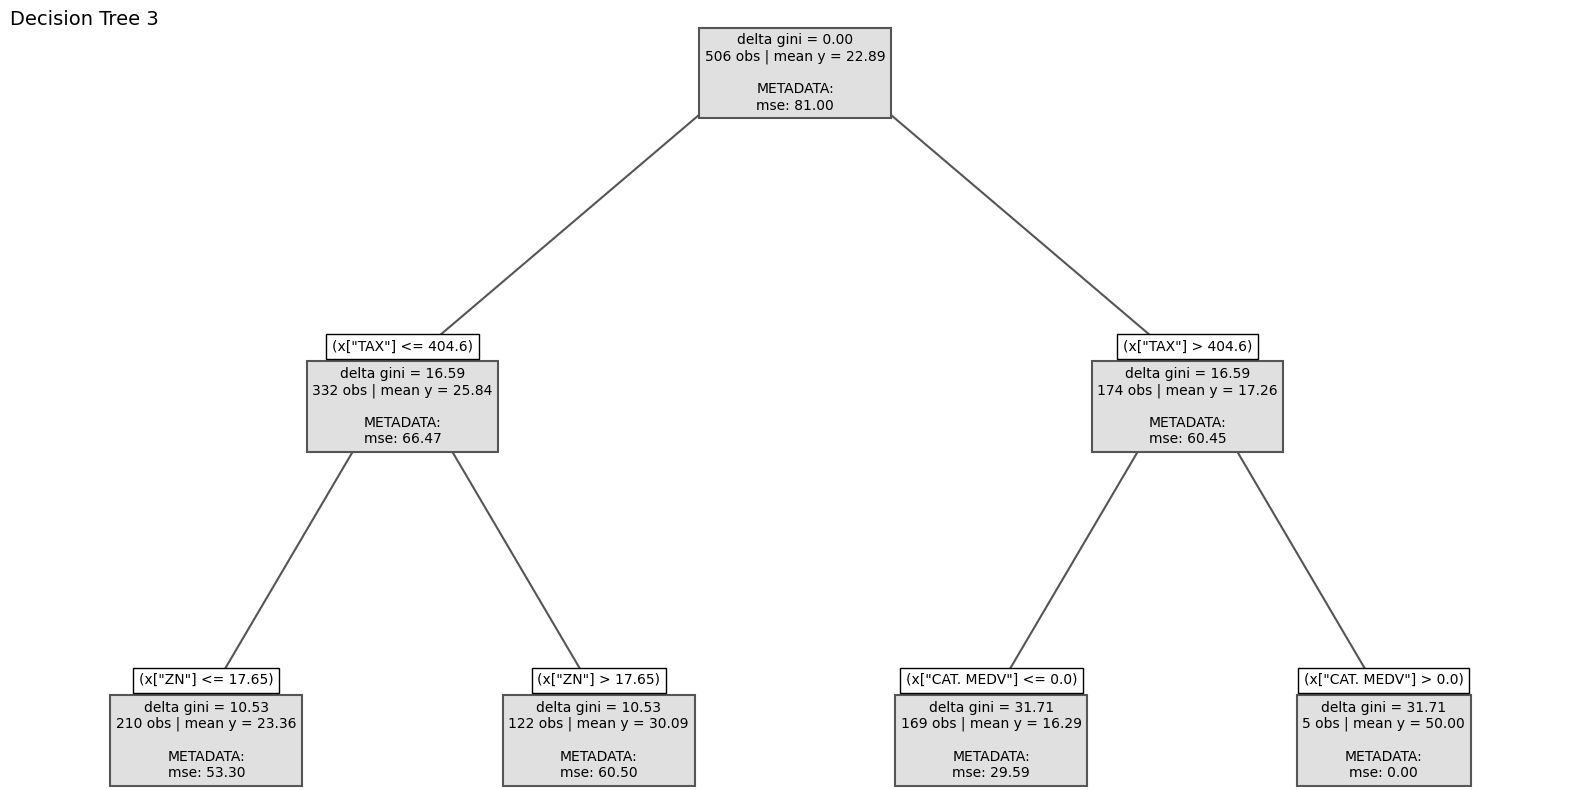

In [7]:
random_forest_regressor.plot_forest(
    n_estimators=3,
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

Get the prediction with `.predict`

In [8]:
probas = random_forest_regressor.predict(
    X=X
)

probas[:5]

array([24.27322518, 22.4947865 , 34.1020342 , 34.39645434, 33.65254926])

You can also obtain the complete predictions for each tree in the forest with `.predict_all`

In [9]:
predictions = random_forest_regressor.predict_all(
    X=X
)

predictions[:5]

[RandomForestPrediction(trees_predictions=[DecisionTreePrediction(value=19.321634615384617, metric=18.023990952555906, metadata={'mse': 26.037}, path=[4, 1, 0]), DecisionTreePrediction(value=26.752023121387285, metric=38.95993277600317, metadata={'mse': 32.029}, path=[5, 2, 0]), DecisionTreePrediction(value=30.093442622950825, metric=10.52654210923997, metadata={'mse': 60.502}, path=[4, 1, 0]), DecisionTreePrediction(value=21.65667870036101, metric=13.705688490997574, metadata={'mse': 12.509}, path=[6, 2, 0]), DecisionTreePrediction(value=22.572357723577237, metric=62.272717488247196, metadata={'mse': 12.942}, path=[3, 1, 0]), DecisionTreePrediction(value=22.918390804597696, metric=8.68702155029194, metadata={'mse': 8.787}, path=[6, 2, 0]), DecisionTreePrediction(value=19.471951219512196, metric=35.459678704060465, metadata={'mse': 46.434}, path=[5, 2, 0]), DecisionTreePrediction(value=19.15801886792453, metric=17.479270893221127, metadata={'mse': 27.227}, path=[3, 1, 0]), DecisionTree